last updated 13/12/24 - Trying Adam, vgg16, CE on Cifar-10 database

- output layer of network needs to output to 10 channels  not the current 11.
- download and seporate cifar 10 into train, val batch
- wont need dataloader - too specific to idsw dataset

To investigate what is wrong with vgg16 learn - i.e. what i've changed.
I am running the 4c model in this file adapted from vgg16.


_save_location, loop_run_name, wandb.init config & notes > for cifar10 sims, included var ds_kw in, or replacing Var_WB_sched

In [1]:
# imports
import torch

import torch.nn as nn
from torchvision.models import vgg16
import torch.optim.lr_scheduler as lr_scheduler
import torch.optim as optim
from torch.utils.data import DataLoader
#from torch.Utils.data import DataLoader
import torch.nn.functional as F
from sklearn.model_selection import train_test_split

import numpy as np
import cv2


from datetime import date
from tqdm import tqdm
import pprint
import collections
from IPython.display import clear_output
#import time
import random
import cv2
import json
import pickle
import os

#import wandb

import sys
sys.path.append('../.')

# data
from functions import ImageProcessor, label_oh_tf#, IDSWDataSetLoader2, get_data
import keras
from keras.datasets import cifar10

#
from fns4wandb import set_lossfn
from plotting import learning_curve, accuracy_curve, plot_confusion

from modelManagment import get_lin_lay, choose_model_out10 #, choose_model2, choose_model1
from loop_fns import train_val_batch, test_loop_batch
from fileManagment import save2csv, save2json

from debuggingFuncs import check_model_sizes_bits
#from torchvision.models import vgg16


#import torch.Utils.data.DataLoader as DataLoader

2024-12-30 11:23:18.285898: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-30 11:23:18.451295: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-12-30 11:23:18.451339: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-12-30 11:23:18.478218: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-30 11:23:18.537192: I tensorflow/core/platform/cpu_feature_guar

In [2]:
# file paths
optimmy = 'adam' #'SGD'
# note. optimizer is a single line in go- changed manually
model_type = 'vgg16'
Var_WB_sched = "NoSched"
ds_kw ="cifar10"
loss_type = 'MSE'

#_save_location = f'/its/home/nn268/antvis/antvis/optics/res_big_loop_saves/models/batch/schedulerRuns/{model_type}/{optimmy}/{ds_kw}/' 
#checkpoint_saveloc = f"/its/home/nn268/antvis/antvis/optics/res_big_loop_saves/models/batch/schedulerRuns/{model_type}/{optimmy}/modelCheckPoints/"
_save_location = f'/its/home/nn268/antvis/antvis/optics/res_big_loop_saves/models/batch/schedulerRuns/{model_type}/cifar10/'
checkpoint_saveloc = _save_location

#data_path = r'/its/home/nn268/antvis/antvis/optics/AugmentedDS_IDSW/'

gitHASH = 'bdb92a70a6d28a07271550d4b602aaa284111019'


start_epoch = 0
epoch_val =  100 #300 #150 #300# 150



loadPreTrainedModel = False

Pp = pprint.PrettyPrinter(indent=4)

device = "cuda:1" if torch.cuda.is_available() else "cpu"

sim_type = "run" #(Test or run)

In [3]:
#wandb.login()
#wandb login --relogin
#wandb.agent

In [4]:
torch.cuda.memory._record_memory_history()

In [5]:
# dictionaries                                                                                  * * * *   SETTINGS   * * * *

date = date.today()
#model_name = model_card['model']
model_card_vgg = {'name': 'vgg', 'model': 'vgg16',
                  'f_lin_lay':[200704,#200704,     #129024,#4096,  # (32x200704 and 3584x4096)
                             200704,      #(16x64512 and 129024x4096)    (16x200704 and 64512x4096)
                             200704,#14336#(16x200704 and 14336x4096)
                             200704,
                             200704, ##(32x200704 and 3584x4096)
                             200704,
                             200704,
                            ],
                 'idx': 0,
                 'dropout':0.2}



resolution_card_452144 = {'resolution':[452,144], 'padding':5, 'index':0}
resolution_card_22672 = {'resolution':[226,72], 'padding':5, 'index':1}
resolution_card_11336 = {'resolution':[113,36], 'padding':2, 'index':2}
resolution_card_5715 = {'resolution':[57,18], 'padding':1, 'index':3}

resolution_card_299 = {'resolution':[29,9], 'padding':0, 'index':4} # 
resolution_card_155 = {'resolution':[15,5], 'padding':0, 'index':5}
resolution_card_83 = {'resolution':[8,3], 'padding':0, 'index':6}



resolution_cards = [resolution_card_452144, resolution_card_11336, resolution_card_5715, resolution_card_155]#]#resolution_card_452144, resolution_card_22672, resolution_card_11336, 
#resolution_card_452144, resolution_card_22672, resolution_card_11336, resolution_card_5715,resolution_card_299, resolution_card_155,
#resolution_cards = [resolution_card_11336] #resolution_card_452144, resolution_card_22672, resolution_card_11336, resolution_card_5715,resolution_card_299, resolution_card_155, resolution_card_83

#learning_rate_cards = [5e-5, 6e-5, 8e-5]
#learning_rate_cards = [8.21592E-05, 6.62E-05, 6.01E-05, 5.97E-05]
learning_rate_cards=  [1e-3] #[0.1, 0.01, 1e-3,1e-4, 1e-5]#, 6e-5, 7e-5, 8e-5]
#wd_cards = [4e-5, 5e-5, 3.00E-05, 2.00E-05]
wd_cards =[0]
#scheduler_cards = [0]#, 0.1, 0.2]

seeds = [8,2,4,42]# 8

#model_cards =[model_card_vgg, model_card_7c3l, model_card_4c3l, model_card_3c2l, model_card_2c2l]
model_cards =[model_card_vgg]

loss_fn_cards = loss_type #['MSE']# ,''] #CrossEntropy
                        
config = dict({'parameters': 'parameters for big loop run'})
config.update({'model_cards':model_cards})
config.update({'resolution_cards':resolution_cards})
config.update({'learning_rate_cards':learning_rate_cards})
config.update({'wd_cards':wd_cards})
config.update({'scheduler':Var_WB_sched})
config.update({'seeds':seeds})
config.update({'loss_fn_cards': loss_fn_cards})


config.update({'batch_size': 32}) #64
config.update({'epochs': epoch_val})
config.update({'start_epoch': start_epoch})


# functions that are moved
save2csv_nest_dict
check_obj4np
save2josn_nested_dict
save2csv
save2json
read_in_json
check_model_sizes_bits
ptrblk_fin_mod_size
train_val_batch
test_loop_batch
get_data
get_lin_lay

In [6]:
import matplotlib.pyplot as plt

def _go(config=None):
    torch.cuda.empty_cache()

    if len(gitHASH) <1:
        print("YOU FORGET THE GIT HASH")
        return
    else:
        #print('Git Hash registered')
        pass
    (x_train, y_train), (x_test, y_test) = cifar10.load_data()
    assert x_train.shape == (50000, 32, 32, 3)
    assert x_test.shape == (10000, 32, 32, 3)
    assert y_train.shape == (50000, 1)
    assert y_test.shape == (10000, 1)#
    x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.3, shuffle=True)
    #print("x train shape  ",x_train.shape)
    #print("y train shape  ",y_train.shape)
    #print("x test shape  ",x_test.shape)
    #print("y test shape  ",y_test.shape)
    #print("x val shape  ",x_val.shape)
    #print("y val shape  ",y_val.shape)
    
    #print(x_train[0].shape)
    #plt.imshow(x_train[4])
    #plt.show()
        
    #with wandb.init(config=config, project=f"{model_type} {epoch_val}E. {ds_kw}. {optimmy}_{sim_type}", notes=f"{model_type} {epoch_val}E {ds_kw} {optimmy}_{sim_type}",):
    #    config = wandb.config
        #start = time.process_time()
    model_card = model_card_vgg
    #print("Current allocated memory (GB):", torch.cuda.memory_allocated() / 1024 ** 3)
            
    model_name = model_card['model']
    model_index = model_card['idx']
    dropout = model_card['dropout'] 
    for res_idx, resolution_card in enumerate(config['resolution_cards']):
        #print("Current allocated memory (GB):", torch.cuda.memory_allocated() / 1024 ** 3)
        resolution = resolution_card['resolution']
        pad = resolution_card['padding']
        lin_lay = get_lin_lay(model_card, resolution)
        print('lin lay', lin_lay)
        scheduler_value = 0
    
        lr = 1e-3#for lr_idx, lr in enumerate(config['learning_rate_cards']):
            
               
        for seed_idx, seed in enumerate(config['seeds']):
            seed = seed
            loss = loss_type#'MSE'
            config['batch_size']

            print('Model: ', str(model_name), f" idx: {0} / {len(config['model_cards'])}")
            print('resolution: ', str(resolution), f" idx: {res_idx} / {len(config['resolution_cards'])}")
            print('learning rate: ', str(lr), f" idx: {0} / {len(config['learning_rate_cards'])}")
            #print('weight decay: ', str(wd_card), f" idx: {wd_idx} / {len(config['wd_cards'])}")
            print('scheduler: ', str(Var_WB_sched))# f" idx: {sched_idx} / {len(config['scheduler_cards'])}")
            print('seed: ', str(seed), f" idx: {seed_idx} / {len(config['seeds'])}")
            print('loss function: ', str(loss))#, f" idx: {0} / {len(config['loss_fn_cards'])}")
            print('Batch size: ', config['batch_size'])
            print('Training epochs: ', config['epochs'])

            epochs = config['epochs'] #40

            IP = ImageProcessor(device)

            #wandb.log({'gitHash':gitHASH})
            #wandb.log({'Epochs': epochs})
            
            #print('3')
            #!nvidia-smi
            
            # set save dictionary
            save_dict = {'Run' : f"{model_name}_{resolution}_{date}_{optimmy}_{config['epochs']}E_{Var_WB_sched}_{sim_type}",
                         'Current_Epoch': config['start_epoch'], # this is where i add the start epoch
                         'start_epoch':config['start_epoch'],
                         'save_location' : _save_location,
                         'checkpoint_save_loc': checkpoint_saveloc,
                         'res': resolution,
                         'sched': Var_WB_sched,
                         'model': model_name,
                         'optimiser':optimmy,
                         'scheduler': Var_WB_sched,
                         'seed':seed}
            
            print("model name", model_name, " flinlay: ", lin_lay, " dropout:", dropout)
            model = choose_model_out10(model_name, lin_lay, dropout).to(device) #choose_model1(model_name, lin_lay, dropout).to(device)#.to(device)
            #check_model_sizes_bits(model)#
            
            if loadPreTrainedModel:
                dir_pkl = f"/its/home/nn268/antvis/antvis/optics/res_big_loop_saves/models/batch/schedulerRuns/{model_type}/{optimmy}/NoSched/"
                pkl_name = f"{model_type}_{resolution}_2024-11-26_{optimmy}_150E_{Var_WB_sched}_{resolution}_0.001_{seed}_CrossEntropy_{optimmy}.pkl"#f"{model_type}_{optimmy}_{Var_WB_sched}_150E_{resolution}_seed{seed}"#_{resolution}_0.001_0_{seed}_CrossEntropy
                with open(dir_pkl+pkl_name, 'rb') as f:
                    model_pkl = torch.load(f)
                model.load_state_dict(model_pkl['model.state_dict'])

            #print("After model init, Before data loading - Current allocated memory (GB):", torch.cuda.memory_allocated(device=device) / 1024 ** 3)
            
            # DATASET
            #x_train, y_train, x_val, y_val, x_test, y_test = get_data(random_seed=seed, file_path=data_path)
            #av_lum = IP.new_luminance(x_train)
            av_lum = 0
            #train_ds = IDSWDataSetLoader2(x_train, y_train, resolution,pad,av_lum,model_name, device)# av_lum, res,pad,
            #train = DataLoader(train_ds, batch_size=config['batch_size'], shuffle=True, drop_last=True) #, num_workers=2

            IP = ImageProcessor(device)
            x_traint= [torch.tensor((cv2.resize(im, (224, 224))/255), dtype=torch.float32).permute(2, 0, 1) for im in x_train]#[IP.colour_size_tense(x, 'colour', (224, 224), av_lum,0, vg=True) for x in x_train]
            x_valt= [torch.tensor((cv2.resize(im, (224, 224))/255), dtype=torch.float32).permute(2, 0, 1) for im in x_val]
            x_testt= [torch.tensor((cv2.resize(im, (224, 224))/255), dtype=torch.float32).permute(2, 0, 1) for im in x_test]
            
            #x_valt= [IP.colour_size_tense(x, 'colour', (224, 224), av_lum,0, vg=True) for x in x_val]
            #x_testt= [IP.colour_size_tense(x, 'colour', (224, 224), av_lum,0, vg=True) for x in x_test]
            y_traint = [label_oh_tf(lab, 10) for lab in y_train]
            y_valt = [label_oh_tf(lab, 10) for lab in y_val]
            y_testt = [label_oh_tf(lab, 10) for lab in y_test]
            #del x_train
            #del y_train
            #del x_val
            #del y_val
            #del x_test
            #del y_test


            #print("y test post processing ",type(y_testt[0]), len(y_testt), y_testt[0].shape)
            #print("x test post processing", type(x_testt[0]), len(x_testt), x_testt[0].shape)
        
            train = DataLoader(list(zip(x_traint, y_traint)), batch_size=config['batch_size'], shuffle=True, drop_last=True)

            #test_ds = IDSWDataSetLoader2(x_test, y_test, resolution,pad,av_lum,model_name, device)
            #test = DataLoader(test_ds, batch_size=config['batch_size'], shuffle=True, drop_last=True) #, num_workers=2
            test = DataLoader(list(zip(x_testt, y_testt)), batch_size=config['batch_size'], shuffle=True, drop_last=True) #, num_workers=2

            #val_ds = IDSWDataSetLoader2(x_val, y_val, resolution,pad,av_lum,model_name, device)
            #val = DataLoader(val_ds, batch_size=config['batch_size'], shuffle=True, drop_last=True) #, num_workers=2
            val = DataLoader(list(zip(x_valt, y_valt)), batch_size=config['batch_size'], shuffle=True, drop_last=True) #, num_workers=2
            #print("train shape", len(train))

            
            #print("After data loading - Current allocated memory (GB):", torch.cuda.memory_allocated(device=device) / 1024 ** 3)
            loss_fn = set_lossfn(loss)
            
            # set optimizer
            optimizer = torch.optim.Adam(model.parameters(),lr=lr) #torch.optim.SGD(model.parameters(), lr=lr)### #torch.optim.SGD(model.parameters(), lr=lr) # 

            #print("MODEL PARAMS : ",model.parameters())
            #for p in model.parameters():
            #    print(p)
            
            #print("After loading Optimizer - Current allocated memory (GB):", torch.cuda.memory_allocated(device=device) / 1024 ** 3)
            #wandb.watch(model, loss_fn, log='all', log_freq=10, idx = model_index)
            #print("Pre Training - Current allocated memory (GB):", torch.cuda.memory_allocated() / 1024 ** 3)

            loop_run_name = f"{save_dict['Run']}_{resolution}_{lr}_{seed}_{loss}_{optimmy}_{ds_kw}"

            model, save_dict=  train_val_batch(model, train,val, loop_run_name,save_dict, lr, loss_fn,epochs, config['batch_size'], optimizer, scheduler_value, device)
            #model, save_dict=  train_val_batch(model, (x_train,y_train),(x_val, y_val), loop_run_name,save_dict, lr, loss_fn,epochs, config['batch_size'], optimizer, scheduler_value, device)

            #print("Post Training - Current allocated memory (GB):", torch.cuda.memory_allocated() / 1024 ** 3)
            
            test_acc,test_predict_list, y_test = test_loop_batch(model,test, loss_fn, config['batch_size'], device) #model, model_name, X, Y, res, pad, loss_fn, device, num_classes=11
            
            #print(test_predict_list)
            print(' \n train Acc: ', save_dict['t_accuracy_list'][-1])
            print(' \n val Acc: ', save_dict['v_accuracy_list'][-1])
            print(' \n test Acc: ', test_acc)
            
            save_dict.update({'test_acc': test_acc})
            save_dict.update({'test_predict': test_predict_list})
            save_dict.update({'test_labels': list(y_test)})

            learning_curve(save_dict['t_loss_list'], save_dict['v_loss_list'], save_location=save_dict['save_location'],run_name=loop_run_name)
            accuracy_curve(save_dict['t_accuracy_list'], save_dict['v_accuracy_list'],save_location=save_dict['save_location'],run_name=loop_run_name)
            test_predict_list=[pred for pred in test_predict_list]
            plot_confusion(predictions= test_predict_list, actual= y_test, title = "Test Confusion matrix", run_name = loop_run_name,save_location =save_dict['save_location'])
            
            #wandb.log({'test_acc': test_acc})
            #wandb.log({'test_predict': test_predict_list})
            #wandb.log({'test_labels': list(y_test)})
            #saving
            diction = {}
            d = date.today()
            d=str(d)
            diction.update({'Date':d})
            diction.update({'gitHASH':str(gitHASH)})
            diction.update({'model_name': str(model_name)})
            diction.update({'loss_fn': str(loss)})
            diction.update({'lr': str(lr)})
            #diction.update({'wd': str(wd_card)})
            #diction.update({'scheduler value': str(scheduler_value)})
            diction.update({'seed': str(seed)})
            diction.update({'resolution': str(resolution)})
            diction.update({'pad': int(pad)})
            diction.update({'lin_lay': int(lin_lay)})
            #diction.update({'run time': (time.process_time() - run_start_time)})
            diction.update(save_dict)
            
            save_location = save_dict['save_location']
            title = save_dict['Run']
            save2json(diction, loop_run_name, save_location)
            save2csv(diction, title, save_location)

            diction['model.state_dict'] = model.state_dict().to('cpu') #to('cpu').

            with open(f"{save_location}{loop_run_name}.pkl", 'wb+') as f:
                #p
                torch.save(diction, f)
            
            #clear_output()

            
            #print(f' \n END {model_name} {resolution} Run Time: ',time.process_time() - run_start_time)
            #!nvidia-smi
            torch.cuda.empty_cache()
        #print('Final Run time: ',time.process_time() - start)
        torch.cuda.empty_cache()

100%|████████████████████████| 100/100 [3:16:38<00:00, 117.98s/it]


9.715544871794872
 
 train Acc:  9.623741994510523
 
 val Acc:  9.815705128205128
 
 test Acc:  9.715544871794872


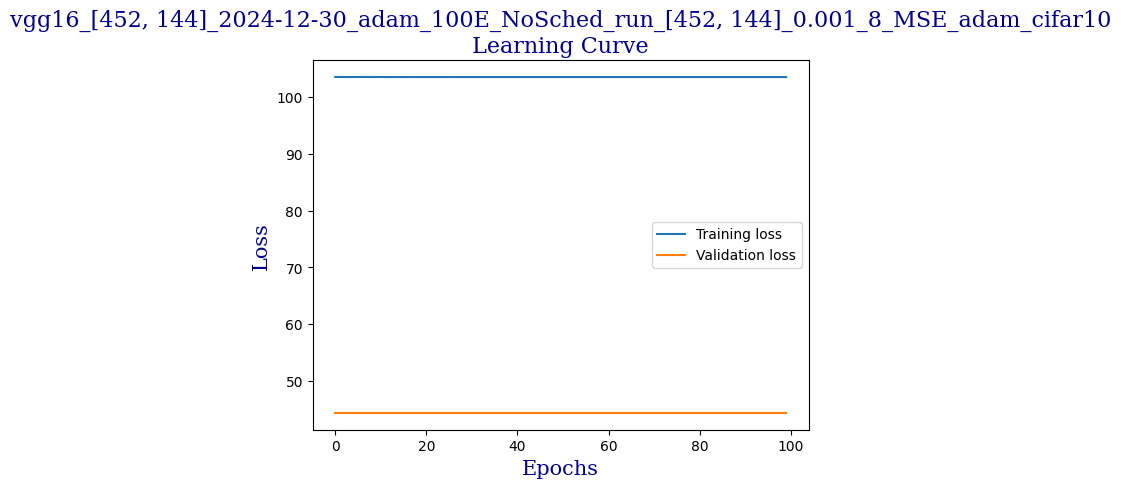

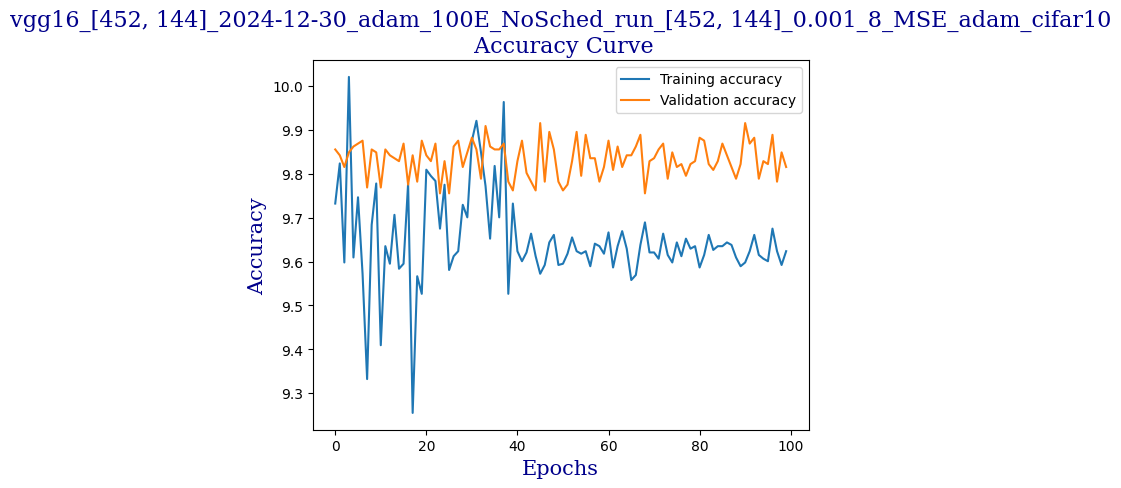

9984 9984


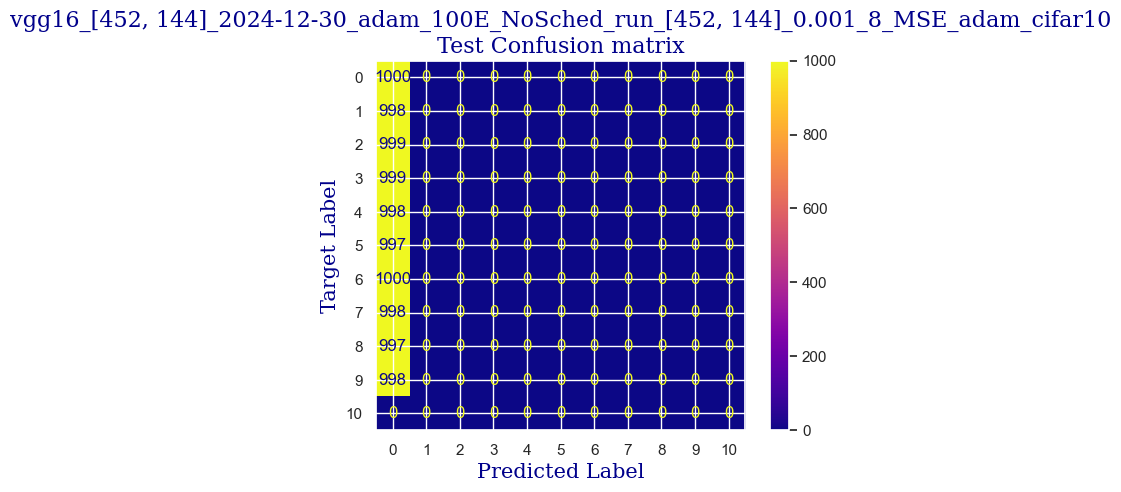

AttributeError: 'collections.OrderedDict' object has no attribute 'to'

In [7]:
_go(config)

# 12.58 GiB. GPU 0 has a total capacty of 23.65 GiB of which 8.04 GiB is free
23.65-8.04
/its/home/nn268/antvis/antvis/optics/res_big_loop_saves/models/batch/schedulerRuns/4c3l/SGD/modelCheckPoints
/its/home/nn268/antvis/antvis/optics/res_big_loop_saves/models/batch/schedulerRuns/4c/SGD/modelCheckPoints


pred torch.Size([11])

lab  torch.Size([5, 11])

In [ ]:
# only things that have been added are more dictionary items

cuda memory error

currently trying to reduce number of vars and delete any large ones after use (del loss after loss has been added to current loss or loss list)

- removeing wanb also helps with reducing memory consumption 16/12/24

14.39  261124 - reducing batch size to 32

worked up to 160E.
will train to 150, then when all done, read in the model files and continue to 300.


In [ ]:
print(torch.cuda.memory_summary(device=device, abbreviated=False))

In [ ]:
torch.cuda.empty_cache()

!nvidia-smi

In [ ]:
/its/home/nn268/antvis/antvis/optics/res_big_loop_saves/models/batch/schedulerRuns/vgg16/adam/NoSched//